In [1]:
## define the environment to work in and install necessary libraries 
User = 'vanessa'

env = input('Select kaggle, colab, or local: ')

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    ! cp /content/drive/MyDrive/val2017.zip ./
    ! unzip -df val2017.zip
    ! pip install kornia

if env == 'kaggle':
    ! pip install torchvision
    ! pip install lpips
    ! pip install torchinfo
    try:
        from torch.hub import load_state_dict_from_url
    except ImportError:
        from torch.utils.model_zoo import load_url as load_state_dict_from_url

    #from fastai.vision.learner import create_body
    #from fastai.vision.models.unet import DynamicUnet
    #from fastai.data.external import untar_data, URLs

else: pass

In [24]:
## Libraries 

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

from skimage.color import rgb2lab, lab2rgb
from kornia.color import rgb_to_lab, lab_to_rgb
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Resize
from torch.hub import load_state_dict_from_url
import lpips

from utils import *
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [3]:
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

## IMAGE COLORIZATION WITH GENERATIVE ADVERSARIAL NETWORK (GAN)

Image colorization is a popular image-to-image translation problem. In this notebook, we focus on image colorization with generative adversarial networks (GANs).

### 1. Data loading and preprocessing
We are using a subset of the COCO dataset [1], since it comprises a wide range of different images, with enough variability. 1/5 of the chosen dataset will be used as validation data, the remaining 4/5 for the training process.

The `ColorizationDataset` class is used to load an image, hence a rank-3 (height, width, color) array with the last axis containing the color data for our image. The latter represents the RGB color space and there are 3 numbers for each pixel indicating the amount of Red, Green, and Blue.

The images are then converted into `Lab` color space, still characterized by three numbers for each pixel. In this case, the first number channel, L, encodes the *Lightness* of each pixel, and it appears as a black and white (B&W) image when visualized. The a and b channels encode how much green-red and yellow-blue each pixel has, respectively. The reason why we chose this color space is explained in our final report.

In [4]:
## config parameters
in_ch_gen = 1   # input channels for generator
out_ch_gen = 2  # out channels for generator
in_ch_dis = in_ch_gen + out_ch_gen  # input channels for discriminator


SIZE = 256      # image size
BATCH_SIZE = 16

In [5]:
### -- Create Dataset class to load coco dataset -- ###


class ColorizationDataset(Dataset):
    # initialise function of class
    def __init__(self, paths, transforms = None):
        '''
            params:
            * paths: path to dataset
            * transforms: transforms to apply to the input image
        '''
        self.paths = paths
        self.transforms = transforms


    # obtain the sample with the given index
    def __getitem__(self, index):
        if index >= len(self.paths):
            raise StopIteration

        # obtain filenames from list
        img = Image.open(self.paths[index]).convert('RGB')
        image = self.transforms(img)

        if image.size()[0] == 3:
            image_lab = rgb_to_lab(image) # Converting RGB to L*a*b
            if User == 'vanessa':
                L = image_lab[[0], ...] / 50. - 1. # Between -1 and 1
                ab = image_lab[[1, 2], ...] / 110. # Between -1 and 1
            elif User == 'javi':
                L = image_lab[[0], ...] / 100. # to [0, 1]
                ab = (image_lab[[1, 2], ...] + 128.) / 255. # to [0, 1]

            return {'L': L, 'ab': ab } # return L, ab channels 

        else:
            del self.paths[index]
            return self.__getitem__(index)

    #  total number of samples 
    def __len__(self):
        return len(self.paths)



def prepare_dataset(env, path = '', n_tot=10000, n_train=8000, seed=1234):
    '''
        Prepare validation and train dataset
        params:
        * env
        * path to data 
        * total number of images in dataset
        * number of images for training
        * seed 

    '''

    if env == 'colab':
        path = '/content/f/val2017'
        n_tot = 5000
        n_train = int(4/5 * n_tot)
        out_dir = '/content/'  

    if env == 'kaggle':

        coco_path = '/kaggle/input/coco-2017-dataset/coco2017'
        #coco_path = untar_data(URLs.COCO_SAMPLE)
        coco_path = coco_path + '/val2017'
        path = coco_path
        n_tot = 5000
        n_train = int(4/5 * n_tot)
        out_dir = '/kaggle/working/'  

    if env == 'local':
        path = '/Volumes/MARINO_HD/padova/3/NN_and_DeepLearning/coco/val2017/' if User == 'javi' else 'val2017'
        n_tot = 5000
        n_train = int(4/5 * n_tot)
        out_dir = './' if User == 'javi' else '/Users/vanessacerrone/Desktop/ImageRecolorization/'


    paths = glob.glob(path + '/*.jpg') # Grabbing all the image file names
    np.random.seed(1234)
    paths_subset = np.random.choice(paths, n_tot, replace=False) # choosing N_tot images randomly
    rand_idxs = np.random.permutation(n_tot)
    train_idxs = rand_idxs[:n_train]                            # choosing the first N_train as training set
    val_idxs = rand_idxs[n_train:]
                                  # choosing last N_tot-N_train as validation set
    train_paths = paths_subset[train_idxs]
    val_paths = paths_subset[val_idxs]

    return train_paths, val_paths, out_dir


redgreen = LinearSegmentedColormap.from_list('rg',['g', 'w', 'r'], N=256) 
blueyellow = LinearSegmentedColormap.from_list('rg',['b', 'w', 'y'], N=256)
    
def visualize_dataset(dataset, N = 16):
    '''
        Function to visualize N images from dataset
    '''
    fig, axs = plt.subplots(4,16, figsize=(32,8))

    for i in range(N):

        L = dataset[i]['L'].squeeze(0).detach().clone()
        a = dataset[i]['ab'][0, :, :].detach().clone()
        b = dataset[i]['ab'][1, :, :].detach().clone()
        
        if User == 'vanessa':
            LAB_img = torch.stack(((L+1.)*50., a*110., b*110.), dim = 0)
        elif User == 'javi':
            LAB_img = torch.stack((L*100., a*255.-128., b*255.-128.), dim = 0)
            
        RGB_IMG = lab_to_rgb(LAB_img).permute(1, 2, 0).numpy()


        axs[0][i].imshow(L.numpy(), cmap = 'gray')
        
        axs[1][i].imshow(a.numpy(), cmap = redgreen)

        axs[2][i].imshow(b.numpy(), cmap = blueyellow)
        
        axs[3][i].imshow(RGB_IMG)
        

        for ax in fig.get_axes():
            ax.set_xticks([])
            ax.set_yticks([])


    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig

def plot_loss(training_loss, validation_loss, title = None, ymin = None, ymax = None):
    '''
        Plot train and validation losses
    '''
    sns.set(style = 'white')
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.plot(training_loss, color = '#004C97', ls = '-', lw = 2, alpha = 0.8, label='Train loss')
    ax.plot(validation_loss,  color = '#AF272F', ls = '--', lw = 2, alpha = 0.8, label='Validation loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right', frameon=False, fontsize=12, ncol=1)
    
    if title != None:
        fig.suptitle(title)
    if ymin != None and ymax != None:
        ax.set_ylim(ymin, ymax)
    fig.tight_layout()

    #fig.savefig('./checkpoints/loss.png')
    plt.show()
    return fig

In [6]:
# Load traning and validation data
train_paths, val_paths, out_dir = prepare_dataset(env, seed = 99)

print(len(train_paths))
print(len(val_paths))
print(out_dir)

4000
1000
/Users/vanessacerrone/Desktop/ImageRecolorization/


In [7]:
# define transforms 
train_transforms = Compose([
    ToTensor(), # this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    Resize((SIZE, SIZE)), 
])

val_transforms = Compose([
    ToTensor(), # this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    Resize((SIZE, SIZE)),

])

# create train and validation datasets
train_dataset = ColorizationDataset(paths = train_paths, transforms = train_transforms)
val_dataset = ColorizationDataset(paths = val_paths, transforms = val_transforms)

print(len(train_dataset), len(val_dataset))

4000 1000


In [8]:
# initialize dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE ,
                                          shuffle=True,
                                          num_workers=1)
                                         
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=1)                         

print(len(train_dataloader), len(val_dataloader))

250 63


In [10]:
## check size of L and ab channels 
data = next(iter(train_dataset))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

torch.Size([1, 256, 256]) torch.Size([2, 256, 256])


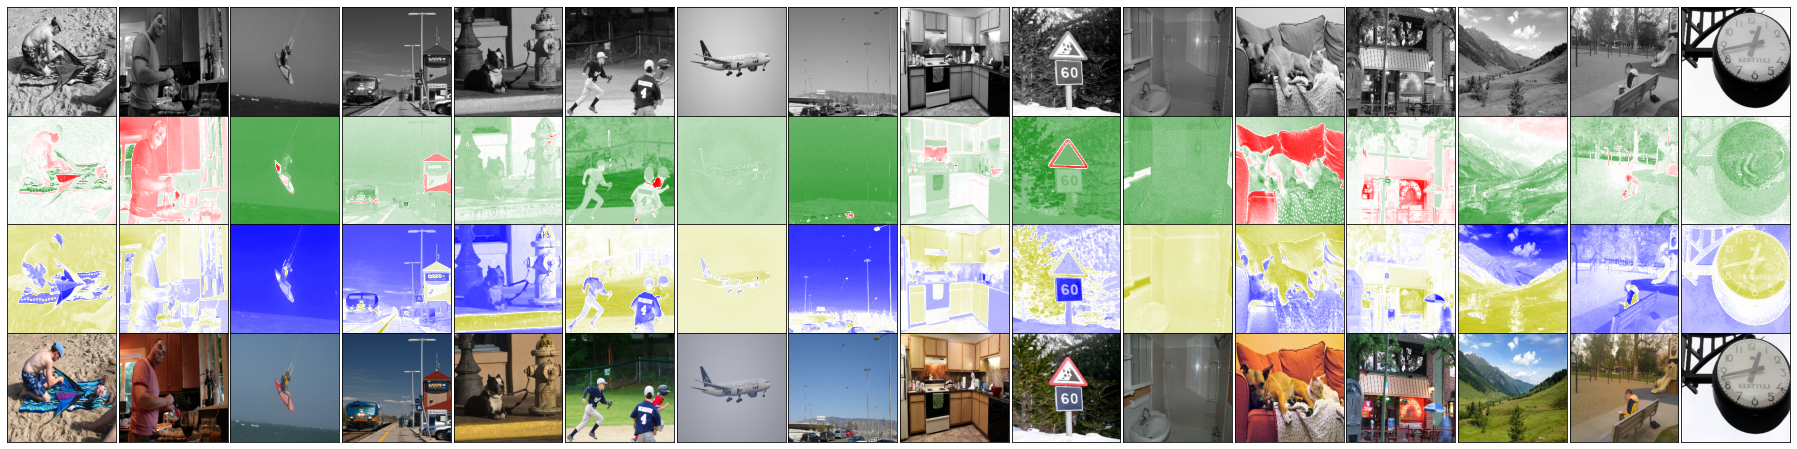

In [11]:
# Visualize some images from dataset 
## First row: L channnel
## Second row: a channel
## Third row: b channel
## Fourth row: reconverted from Lab to RGB 

fig = visualize_dataset(train_dataset)
plt.show()

## 2. UNet Autoencoder

### Architecture

In [13]:
class UNetAutoencoder_final(nn.Module):
    def __init__(
        self,
        in_channels = 1,
        n_classes = 2,
        padding = True,
        batch_norm = True,
        dropout = True,
        linear_enc = True
    ):

        super(UNetAutoencoder_final, self).__init__()
        self.linear_enc = linear_enc

        '''
        Implementation of UNet Convolutional Autoencoder.
        The implementation is based on https://arxiv.org/abs/1505.04597 (Ronneberger et al., 2015)
        with some tweaks.
        An optional BatchNormalization layer has been applied after each of the ReLU activation functions
        Also optional dropout has been added after each of the convolutional blocks
        Padding is set to True so as to obtain a final output of the same size as the input
        
        Care has to be taken to choose an input size divisible by 2 (depth of the net-1) times.
        In this case, it should be divisible by 2 at least 4 times.
        '''
        
        

        '''
        first down-block
        '''
        first_block = []
        first_block.append(nn.Conv2d(in_channels, 64, kernel_size = 3, padding = int(padding)))
        first_block.append(nn.ReLU())
        if batch_norm:
            first_block.append(nn.BatchNorm2d(64))
        first_block.append(nn.Conv2d(64, 64, kernel_size = 3, padding=int(padding)))
        first_block.append(nn.ReLU())
        if dropout:
            first_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            first_block.append(nn.BatchNorm2d(64))
        self.first_block = nn.Sequential(*first_block)

        # maxpool2d will half the input shape here

        '''
        second down-block
        '''
        second_block = []
        second_block.append(nn.Conv2d(64, 128, kernel_size = 3, padding = int(padding)))
        second_block.append(nn.ReLU())
        if batch_norm:
            second_block.append(nn.BatchNorm2d(128))
        second_block.append(nn.Conv2d(128, 128, kernel_size = 3, padding=int(padding)))
        second_block.append(nn.ReLU())
        if dropout:
            second_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            second_block.append(nn.BatchNorm2d(128))
        self.second_block = nn.Sequential(*second_block)
        
        # maxpool2d will half the input shape here

        '''
        third down-block
        '''
        third_block = []
        third_block.append(nn.Conv2d(128, 256, kernel_size = 3, padding = int(padding)))
        third_block.append(nn.ReLU())
        if batch_norm:
            third_block.append(nn.BatchNorm2d(256))
        third_block.append(nn.Conv2d(256, 256, kernel_size = 3, padding=int(padding)))
        third_block.append(nn.ReLU())
        if dropout:
            third_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            third_block.append(nn.BatchNorm2d(256))
        self.third_block = nn.Sequential(*third_block)

        # maxpool2d will half the input shape here

        '''
        fourth down-block
        '''
        fourth_block = []
        fourth_block.append(nn.Conv2d(256, 512, kernel_size = 3, padding = int(padding)))
        fourth_block.append(nn.ReLU())
        if batch_norm:
            fourth_block.append(nn.BatchNorm2d(512))
        fourth_block.append(nn.Conv2d(512, 512, kernel_size = 3, padding=int(padding)))
        fourth_block.append(nn.ReLU())
        if dropout:
            fourth_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            fourth_block.append(nn.BatchNorm2d(512))
        self.fourth_block = nn.Sequential(*fourth_block)

        # maxpool2d will half the input shape here

        '''
        fifth down-block
        '''
        fifth_block = []
        fifth_block.append(nn.Conv2d(512, 1024, kernel_size = 3, padding = int(padding)))
        fifth_block.append(nn.ReLU())
        if batch_norm:
            fifth_block.append(nn.BatchNorm2d(1024))
        fifth_block.append(nn.Conv2d(1024, 1024, kernel_size = 3, padding=int(padding)))
        fifth_block.append(nn.ReLU())
        if dropout:
            fifth_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            fifth_block.append(nn.BatchNorm2d(1024))
        self.fifth_block = nn.Sequential(*fifth_block)



        # NO maxpooling after the last convolutional block
        # the image in the encoded region is 16x16 (for a 256x256 input with padding = True)
        
        if linear_enc:
            flattenLayer = []
            flattenLayer.append(nn.Flatten(start_dim=1))
            flattenLayer.append(nn.Linear(in_features=1024 * 16 * 16, out_features=512))
            flattenLayer.append(nn.ReLU(True))
            self.flattenLayer = nn.Sequential(*flattenLayer)

            unflattenLayer = []

            unflattenLayer.append(nn.Linear(in_features=512, out_features=1024 * 16 * 16))
            unflattenLayer.append(nn.ReLU(True))
            unflattenLayer.append(nn.Unflatten(dim=1, unflattened_size=(1024, 16, 16)))
            self.unflattenLayer = nn.Sequential(*unflattenLayer)

        
        '''
        first up-block
        '''
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        
        # here we shall apply bridge from fourth block

        # 3x3 conv block
        sixth_block = []
        sixth_block.append(nn.Conv2d(1024, 512, kernel_size = 3, padding = int(padding)))
        sixth_block.append(nn.ReLU())
        if batch_norm:
            sixth_block.append(nn.BatchNorm2d(512))
        sixth_block.append(nn.Conv2d(512, 512, kernel_size = 3, padding=int(padding)))
        sixth_block.append(nn.ReLU())
        if dropout:
            sixth_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            sixth_block.append(nn.BatchNorm2d(512))
        self.sixth_block = nn.Sequential(*sixth_block)


        '''
        second up-block
        '''
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        
        # here we shall apply bridge from third block

        # 3x3 conv block
        seventh_block = []
        seventh_block.append(nn.Conv2d(512, 256, kernel_size = 3, padding = int(padding)))
        seventh_block.append(nn.ReLU())
        if batch_norm:
            seventh_block.append(nn.BatchNorm2d(256))
        seventh_block.append(nn.Conv2d(256, 256, kernel_size = 3, padding=int(padding)))
        seventh_block.append(nn.ReLU())
        if dropout:
            seventh_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            seventh_block.append(nn.BatchNorm2d(256))
        self.seventh_block = nn.Sequential(*seventh_block)


        '''
        third up-block
        '''
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)

        # here we shall apply bridge from second block

        # 3x3 conv block
        eighth_block = []
        eighth_block.append(nn.Conv2d(256, 128, kernel_size = 3, padding = int(padding)))
        eighth_block.append(nn.ReLU())
        if batch_norm:
            eighth_block.append(nn.BatchNorm2d(128))
        eighth_block.append(nn.Conv2d(128, 128, kernel_size = 3, padding=int(padding)))
        eighth_block.append(nn.ReLU())
        if dropout:
            eighth_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            eighth_block.append(nn.BatchNorm2d(128))
        self.eighth_block = nn.Sequential(*eighth_block)


        '''
        fourth up-block
        '''
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        
        # here we shall apply bridge from second block
        
        # 3x3 conv block
        nineth_block = []
        nineth_block.append(nn.Conv2d(128, 64, kernel_size = 3, padding = int(padding)))
        nineth_block.append(nn.ReLU())
        if batch_norm:
            nineth_block.append(nn.BatchNorm2d(64))
        nineth_block.append(nn.Conv2d(64, 64, kernel_size = 3, padding=int(padding)))
        nineth_block.append(nn.ReLU())
        if dropout:
            nineth_block.append(nn.Dropout2d(p = 0.15))
        if batch_norm:
            nineth_block.append(nn.BatchNorm2d(64))
        self.nineth_block = nn.Sequential(*nineth_block)


        self.last = nn.Conv2d(64, n_classes, kernel_size = 1)
    
    def center_crop(self, layer, target_size):
        '''
        function to obtain a center crop of the feature map in the down path
        so as to concatenate with the upconvolution feature map
        
        In the case of padding = True, this will return the whole down-sampling layer
        because the up-sampling part will have the same size, allowing them to be concatenated directly
        
        In the case of padding = False, a center crop of the downsampling feature maps will be extracted
        to be concatenated with the upsampling feature maps
        '''
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])]


    def forward(self, x):
        '''
        we need to separate the maxpooling from the convolutional part,
        since the maxpooling will go in the downsampling path
        and the result of the convolution is bridged to the upsampling/upconvoluting path
        '''
        
        x_first_block = self.first_block(x)
        x_pooled = F.max_pool2d(x_first_block, 2)

        x_second_block = self.second_block(x_pooled)
        x_pooled = F.max_pool2d(x_second_block, 2)

        x_third_block = self.third_block(x_pooled)
        x_pooled = F.max_pool2d(x_third_block, 2)

        x_fourth_block = self.fourth_block(x_pooled)
        x_pooled = F.max_pool2d(x_fourth_block, 2)

        x_fifth_block = self.fifth_block(x_pooled) 
        
        if self.linear_enc:
            x_fifth_block = self.unflattenLayer(self.flattenLayer(x_fifth_block))
        
        x_up1 = self.up1(x_fifth_block)
        
        # cropping the image of the fourth block to concatenate with x_up1
        crop1 = self.center_crop(x_fourth_block, x_up1.shape[2:])
        
        # apply the conv2d to the concatenation
        x_sixth_block = self.sixth_block(torch.cat([x_up1, crop1], 1))

        
        x_up2 = self.up2(x_sixth_block)    
        
        # cropping the image of the third block to concatenate with x_up2
        crop2 = self.center_crop(x_third_block, x_up2.shape[2:])
        
        # apply the conv2d to the concatenation
        x_seventh_block = self.seventh_block(torch.cat([x_up2, crop2], 1))
        

        x_up3 = self.up3(x_seventh_block)                                

        # cropping the image of the second block to concatenate with x_up3
        crop3 = self.center_crop(x_second_block, x_up3.shape[2:])

        # apply the conv2d to the concatenation
        x_eighth_block = self.eighth_block(torch.cat([x_up3, crop3], 1))

        
        x_up4 = self.up4(x_eighth_block)                                

        # cropping the image of the first block to concatenate with x_up4
        crop4 = self.center_crop(x_first_block, x_up4.shape[2:])

        # apply the conv2d to the concatenation
        x_nineth_block = self.nineth_block(torch.cat([x_up4, crop4], 1))
        
        # apply 1x1 last convolution
        output = self.last(x_nineth_block)
        return output
    
    '''def _init_weights(self, module): # initialize weights 
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.normal_(module.weight, 0, np.sqrt(2 / module.weight.shape[1])) # getting a std dev of sqrt(2/in_channels)
            if module.bias is not None:
                module.bias.data.zero_()'''

In [14]:
# Initialize the Autoencoder
model = UNetAutoencoder_final(in_channels = 1, n_classes = 2, padding = True, batch_norm = True, dropout = True, linear_enc = True)
model.to(device)
print(summary(model, input_size=(BATCH_SIZE, 1, SIZE, SIZE)))

Layer (type:depth-idx)                   Output Shape              Param #
UNetAutoencoder_final                    [16, 2, 256, 256]         --
├─Sequential: 1-1                        [16, 64, 256, 256]        --
│    └─Conv2d: 2-1                       [16, 64, 256, 256]        640
│    └─ReLU: 2-2                         [16, 64, 256, 256]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 256, 256]        128
│    └─Conv2d: 2-4                       [16, 64, 256, 256]        36,928
│    └─ReLU: 2-5                         [16, 64, 256, 256]        --
│    └─Dropout2d: 2-6                    [16, 64, 256, 256]        --
│    └─BatchNorm2d: 2-7                  [16, 64, 256, 256]        128
├─Sequential: 1-2                        [16, 128, 128, 128]       --
│    └─Conv2d: 2-8                       [16, 128, 128, 128]       73,856
│    └─ReLU: 2-9                         [16, 128, 128, 128]       --
│    └─BatchNorm2d: 2-10                 [16, 128, 128, 128]       256
│  

### 2.1 Training

In [ ]:
### Training function
def train_L_epoch(model, device, dataloader, loss_fn, optimizer):

    # Set train mode
    model.train()
    losses = []
    # Iterate the dataloader
    for image_batch in tqdm(dataloader):
        # Move tensor to the proper device
        image_batch_L = image_batch["L"].to(device)
        image_batch_ab = image_batch["ab"].to(device)

        # Encode and decode data
        dec_img = model(image_batch_L)
        
        if str(loss_fn)[:5] == "LPIPS":
            orig_RGB = lab_to_rgb(torch.cat((image_batch_L.cpu()*100., image_batch_ab[:, 0, :, :].cpu().unsqueeze(1)*255.-128, image_batch_ab[:, 1, :, :].cpu().unsqueeze(1)*255.-128.), dim = 1))
            rec_img = lab_to_rgb(torch.cat((image_batch_L.cpu()*100., dec_img[:, 0, :, :].cpu().unsqueeze(1)*255.-128, dec_img[:, 1, :, :].cpu().unsqueeze(1)*255.-128.), dim = 1))

            # Evaluate loss
            loss = loss_fn.forward(rec_img, orig_RGB)
        else:
            # Evaluate loss
            loss = loss_fn(dec_img, image_batch_ab)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        losses.append(loss.detach().cpu().numpy())
    
    losses = np.mean(losses)
    return losses


### Validation function comparing only ab channels
def val_ab_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_decoded = []
        conc_input = []
        for image_batch in tqdm(dataloader):
            # Move tensor to the proper device
            image_batch_L = image_batch["L"].to(device)
            image_batch_ab = image_batch["ab"].to(device)
            # Encode data
            dec_img = model(image_batch_L)


            if str(loss_fn)[:5] == "LPIPS":
                orig_RGB = lab_to_rgb(torch.cat((image_batch_L.cpu()*100., image_batch_ab[:, 0, :, :].cpu().unsqueeze(1)*255.-128, image_batch_ab[:, 1, :, :].cpu().unsqueeze(1)*255.-128.), dim = 1))
                rec_img = lab_to_rgb(torch.cat((image_batch_L.cpu()*100., dec_img[:, 0, :, :].cpu().unsqueeze(1)*255.-128, dec_img[:, 1, :, :].cpu().unsqueeze(1)*255.-128.), dim = 1))

                # Append the network output and the original image to the lists
                conc_decoded.append(rec_img.cpu())
                conc_input.append(orig_RGB.cpu())
            else:
                # Append the network output and the original image to the lists
                conc_decoded.append(dec_img.cpu())
                conc_input.append(image_batch_ab.cpu())

        # Create a single tensor with all the values in the lists
        conc_decoded = torch.cat(conc_decoded)
        conc_input = torch.cat(conc_input) 
        # Evaluate global loss
        val_loss = loss_fn(conc_decoded, conc_input)
    return val_loss.data

def plot_progress_multiple(dataset, model, device, epoch, n_im = 2):
    
    ### Plot progress
    fig, axs = plt.subplots(3, 4, figsize=(24, 24))
    for i in range(4):
         # Get the output of a specific image (the val image at index 0 in this case)
        L = dataset[n_im + i]["L"][0, :, :].squeeze(0).detach().clone().to(device)
        a = dataset[n_im + i]["ab"][0, :, :].detach().clone().to(device)
        b = dataset[n_im + i]["ab"][1, :, :].detach().clone().to(device)
        original_LAB = torch.stack((L*100., a*255.-128, b*255.-128.), dim = 0)
        
        model.to(device)
        model.eval()
        with torch.no_grad():
            # Encode and decode data
            dec_img = model(L.unsqueeze(0).unsqueeze(0)) # [batch x 1 x SIZExSIZE] as it expects 4d input

        rec_a = dec_img[0][0]
        rec_b = dec_img[0][1]
        
        # Plot the reconstructed image
        axs[0][i].imshow(L.cpu(), cmap = "gist_gray")
        axs[0][i].set_title("L true[%s]" % (n_im + i))
        
        axs[1][i].imshow(lab_to_rgb(original_LAB).permute(1, 2, 0).cpu().numpy())
        axs[1][i].set_title("Color true[%s]" % (n_im + i))

        axs[2][i].imshow(lab_to_rgb(torch.stack((L*100., rec_a*255.-128., rec_b*255.-128.), dim = 0)).permute(1, 2, 0).cpu().numpy())
        axs[2][i].set_title("Color reco[%s] (EPOCH %d)" % ((n_im + i), (epoch + 1)))

        for j in range(3):
            axs[j][i].set_xticks([])
            axs[j][i].set_yticks([])
            

    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs(out_dir + 'UNetAutoencoder_final_progress_%d_features' % (16*16), exist_ok=True)
    fig.savefig(out_dir + 'UNetAutoencoder_final_progress_%d_features/epoch_%d.jpg' % ((16*16), epoch + 1))
    plt.show()
    plt.close()
    
    
    
    
def plot_progress(dataset, model, device, epoch, n_im = 2):
    
    ### Plot progress
    fig, axs = plt.subplots(1, 7, figsize=(24, 12))
    # Get the output of a specific image (the val image at index 0 in this case)
    L = dataset[n_im]["L"][0, :, :].squeeze(0).detach().clone().to(device)   # [SIZExSIZE]
    a = dataset[n_im]["ab"][0, :, :].detach().clone().to(device)             # [SIZExSIZE]
    b = dataset[n_im]["ab"][1, :, :].detach().clone().to(device)             # [SIZExSIZE]
    original_LAB = torch.stack((L*100., a*255.-128, b*255.-128.), dim = 0)                  # [3xSIZExSIZE]

    model.to(device)
    model.eval()
    with torch.no_grad():
        # Encode and decode data
        dec_img = model(L.unsqueeze(0).unsqueeze(0)) # [batch x 1 x SIZExSIZE] as it expects 4d input

    rec_a = dec_img[0][0]
    rec_b = dec_img[0][1]

    # Plot the reconstructed image
    axs[0].imshow(L.cpu(), cmap = "gist_gray")
    axs[0].set_title("L[%s]" % n_im)

    axs[1].imshow(rec_a.detach().cpu().numpy(), cmap = redgreen)
    axs[1].set_title("generated a[%s] (EPOCH %d)" % (n_im, (epoch + 1)))

    axs[2].imshow(a.cpu().numpy(), cmap = redgreen)
    axs[2].set_title("original a[%s]" % n_im)

    axs[3].imshow(rec_b.detach().cpu().numpy(), cmap = blueyellow)
    axs[3].set_title("generated b[%s] (EPOCH %d)" % (n_im, (epoch + 1)))

    axs[4].imshow(b.cpu().numpy(), cmap = blueyellow)
    axs[4].set_title("original b[%s]" % n_im)

    axs[5].imshow(lab_to_rgb(torch.stack((L*100., rec_a*255.-128., rec_b*255.-128.), dim = 0)).permute(1, 2, 0).cpu().numpy())
    axs[5].set_title("recolored RGB[%s] (EPOCH %d)" % (n_im, (epoch + 1)))

    axs[6].imshow(lab_to_rgb(original_LAB).permute(1, 2, 0).cpu().numpy())
    axs[6].set_title("original RGB[%s]" % n_im)

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    #plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    '''os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))'''
    plt.show()
    plt.close()

### Training cycle

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

saving_name = out_dir + "UNetAutoencoder_Linear" + str(criterion)[:str(criterion).find("(")] + "_" + str(optimizer)[:str(optimizer).find(" (")]

In [ ]:
### Training cycle
num_epochs = 30
train_losses = []
val_losses = []
n_im = np.random.randint(0, len(val_dataset)) # get random sample to track progress through epochs
for epoch in range(num_epochs):
    print('\nEPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_L_epoch(
        model = model,
        device=device, 
        dataloader=train_dataloader, 
        loss_fn = criterion, 
        optimizer = optimizer
    )
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}')

    ### Validation  (use the validation function)
    val_loss = val_ab_epoch(
        model = model,
        device=device, 
        dataloader=val_dataloader, 
        loss_fn = criterion)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    plot_progress_multiple(dataset = val_dataset, model = model, device = device, epoch = epoch, n_im = 153)
    

# save network params
torch.save(model.state_dict(), saving_name + "_epoch%d_params.pth" % (epoch+1))
print("Saved Model")
    
np.savetxt("%s_train_losses.txt" % saving_name, train_losses, delimiter=';')
np.savetxt("%s_val_losses.txt" % saving_name, val_losses, delimiter=';')

### 3. Results

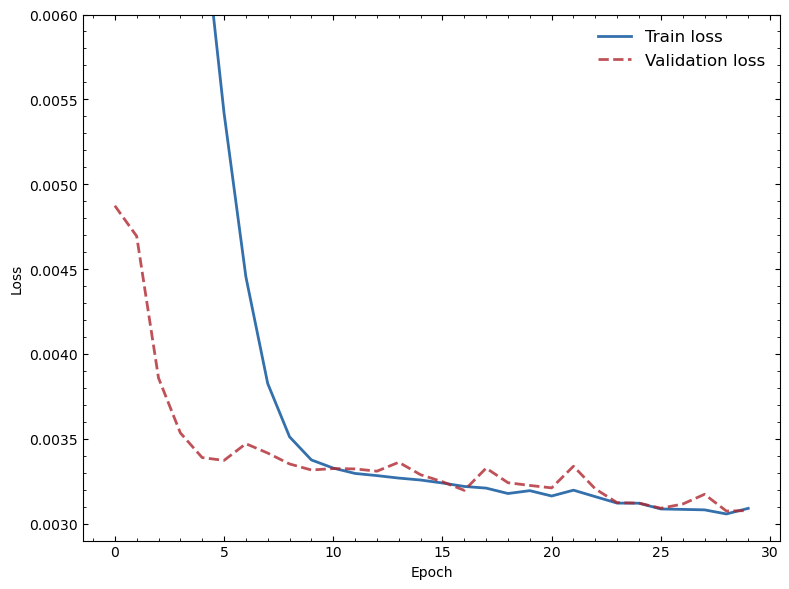

In [32]:
LinearLayer_train_losses = np.loadtxt("final_results/UNetAutoencoder_final_withLinearLayer/UNetAutoencoder_LinearMSELoss_Adam_train_losses.txt" ,delimiter = ';')
LinearLayer_val_losses = np.loadtxt("final_results/UNetAutoencoder_final_withLinearLayer/UNetAutoencoder_LinearMSELoss_Adam_val_losses.txt" ,delimiter = ';')

fig = plot_loss(LinearLayer_train_losses, LinearLayer_val_losses, ymin = 2.9e-3, ymax = 6e-3)
fig.savefig(out_dir + "final_results/linearLayer.pdf")

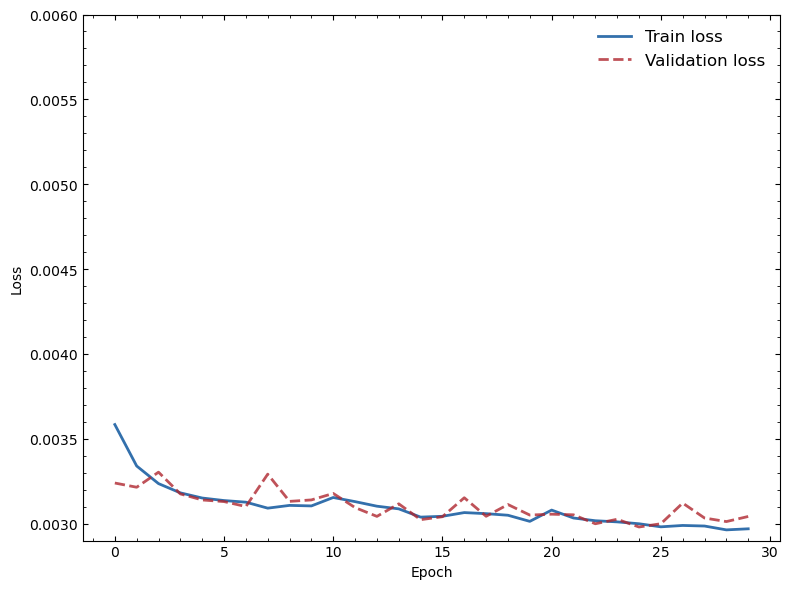

In [35]:
Full_train_losses = np.loadtxt("final_results/UNetAutoencoder_final_30epoch_Adam_MSELoss_BatchNorm_Dropout/UNetAutoencoder_finalMSELoss_Adam_train_losses.txt" ,delimiter = ';')
Full_val_losses = np.loadtxt("final_results/UNetAutoencoder_final_30epoch_Adam_MSELoss_BatchNorm_Dropout/UNetAutoencoder_finalMSELoss_Adam_val_losses.txt" ,delimiter = ';')

fig = plot_loss(Full_train_losses, Full_val_losses, ymin = 2.9e-3, ymax = 6e-3)
fig.savefig(out_dir + "final_results/withoutlinearLayer.pdf")

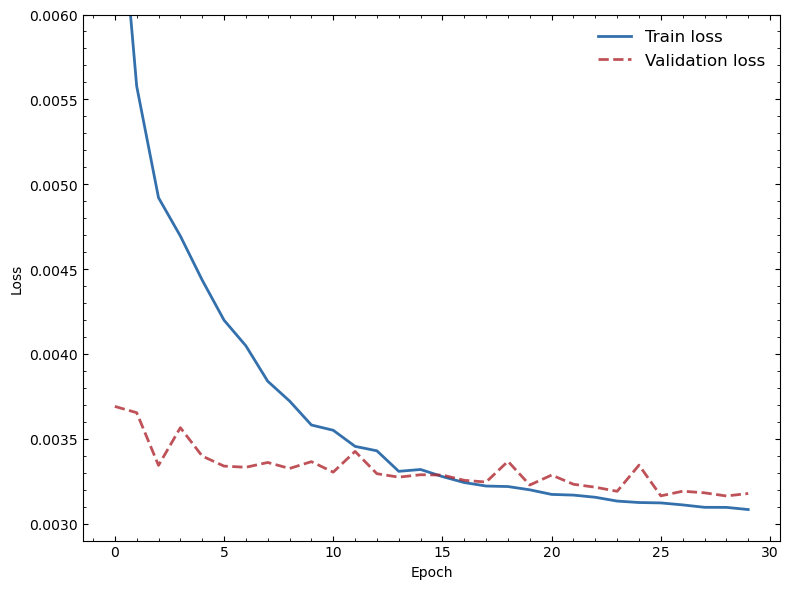

In [36]:
noBatchNorm_train_losses = np.loadtxt("final_results/UNetAutoencoder_final_30epoch_Adam_MSELoss_noBatchNorm_Dropout/UNetAutoencoder_final_noBatchMSELoss_Adam_train_losses.txt" ,delimiter = ';')
noBatchNorm_val_losses = np.loadtxt("final_results/UNetAutoencoder_final_30epoch_Adam_MSELoss_noBatchNorm_Dropout/UNetAutoencoder_final_noBatchMSELoss_Adam_val_losses.txt" ,delimiter = ';')

fig = plot_loss(noBatchNorm_train_losses, noBatchNorm_val_losses, ymin = 2.9e-3, ymax = 6e-3)
fig.savefig(out_dir + "final_results/noBatchNorm.pdf")

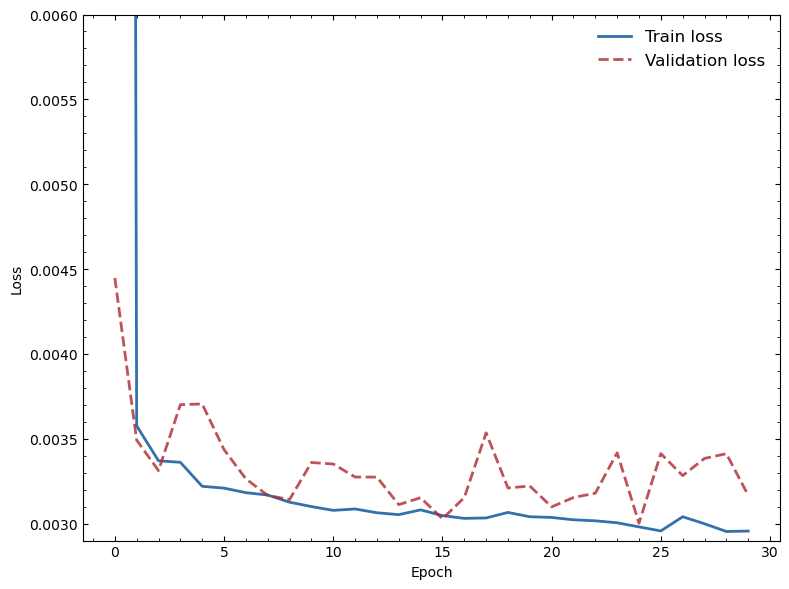

In [38]:
noDropout_train_losses = np.loadtxt("final_results/UNetAutoencoder_final_30epoch_Adam_MSELoss_BatchNorm_noDropout/UNetAutoencoder_final_noDropoutMSELoss_Adam_train_losses.txt" ,delimiter = ';')
noDropout_val_losses = np.loadtxt("final_results/UNetAutoencoder_final_30epoch_Adam_MSELoss_BatchNorm_noDropout/UNetAutoencoder_final_noDropoutMSELoss_Adam_val_losses.txt" ,delimiter = ';')

fig = plot_loss(noDropout_train_losses, noDropout_val_losses, ymin = 2.9e-3, ymax = 6e-3)
fig.savefig(out_dir + "final_results/noDropout.pdf")

In [51]:
print(noDropout_val_losses[14])
print(noDropout_val_losses[29])
print(min(noDropout_val_losses))

0.0031528042163699865
0.0031670304015278816
0.0030026505701243877


## 3. GAN and network structure 

A generative adversarial network (GAN)[2] is a generative model, consisting in two competing neural networks:

- A **generator** ($\mathcal{G}$), which is trained to capture the data distribution from the training data, starting from input random noise, and reproduce it. 
- A **discriminator** ($\mathcal{D}$), which is trained to discriminate whether an image is real (from dataset) or fake (generated by $\mathcal{G}$).

The generator takes gray-scale images (L channel from Lab color space) as input, and generates the two ab channels. The discriminator is trained both on ab channels of ground-truth images and on the generated images, to determine whether the image under study is fake or real. Thus, the discriminator gets images from both the generator and the label, along with the grayscale input, and tries to infer which pair contains the real colored image.

Training a conditional GAN implies training both networks simultaneously: the generator to produce data that is able to *trick* the discriminator; the latter to be able to distinguish between real and fake data. The training procedure is diagrammatically depicted in the following figure.

To maximize the performance of the generator, we need to maximize the loss of the discriminator when given generated labeled data. Namely, the aim of the generator is to produce labeled data that the discriminator classifies as real. On the other hand, to maximize the performance of the discriminator, we need to minimize the loss of the discriminator when given batches of both real and generated labeled data. Therefore, the goal of the discriminator is not to be tricked by the generator.


![network](diagrams/network_GAN-1.png)

### 2.1 Generator architecture

The architecture of generator is based upon an *encoder-decoder* scheme. In the decoder layers, skip-connections are added between its mirror encoder layers by means of a feature map before moving on to the next layer. This technique is called U-Net [3]. It is a convolutional neural network architecture suitable for fast and precise segmentation of images. Some modifications with respect to the model proposed in [4] are added during the experiments, in order to investigate their impact on the overall efficiency of the method. 

The baseline architecture is detailed in the following diagram:

![generator](diagrams/generatorv2-1.png)

In [12]:
'''
    Network structure based upon pix2pix model by Isola Phillip et al.
    https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
'''

### –-- ENCODER --- ###
class EncoderBlock(nn.Module):

    def __init__(self, in_size, out_size, kernel_size=4, padding=1, stride=2, batch_norm=True,
                instance_norm=False,  leaky_relu_slope=0.2):
        '''
        Convolutional encoder block
        * in_size: input depth
        * out_size: output depth
        * kernel_size: kernel size
        * padding: padding
        * stride: stride
        * batch_norm: whether to use batch normalization
        * instance_norm: whether to use instance normalization (e.g, for 1-dim batches)
        * leaky_relu_slope: slope of leaky ReLU
        '''

        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride,
                      bias=False),
            nn.BatchNorm2d(out_size) if (batch_norm and not instance_norm) else None,
            nn.InstanceNorm2d(out_size, affine=True) if (batch_norm and instance_norm) else None,
            nn.LeakyReLU(inplace=True, negative_slope=leaky_relu_slope))

        # remove None from conv_block
        self.conv_block = nn.Sequential(*[x for x in self.conv_block if x is not None])

    def forward(self, x):

        y = self.conv_block(x)

        return y


### –-- DECODER --- ###
class DecoderBlock(nn.Module):

    def __init__(self, in_size, out_size, kernel_size=4, padding=1, stride=2, batch_norm=True,
                 instance_norm=False, apply_dropout=True, dropout_p=0.2):
        '''
        Convolutional decoder block
        * in_size: input depth
        * out_size: output depth
        * kernel_size: kernel size
        * padding: padding
        * stride: stride
        * batch_norm: whether to use batch normalization
        * instance_norm: whether to use instance normalization (e.g, for 1-dim batches)
        * apply_dropout: whether to apply dropout
        * dropout_p: dropout probability
        '''

        super().__init__()

        self.transpose_conv_block = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=kernel_size, padding=padding,
                               stride=stride, bias=False),
            nn.BatchNorm2d(out_size) if (batch_norm and not instance_norm) else None,
            nn.InstanceNorm2d(out_size, affine=True) if (batch_norm and instance_norm) else None,
            nn.Dropout2d(p=dropout_p) if apply_dropout else None,
            nn.ReLU(inplace=True))

        # remove None from conv_block
        self.transpose_conv_block = nn.Sequential(
            *[x for x in self.transpose_conv_block if x is not None])

    def forward(self, x):

        y = self.transpose_conv_block(x)

        return y   

In [13]:
class Generator(nn.Module):

    def __init__(self, in_channels=1, out_channels=2, instance_norm=False,
                 leaky_relu_slope=0.2):
        '''
            Generator network
            * in_channels: input channels, 1 for grayscale
            * out_channels: output channels, 2 for ab channels 
            * leaky_relu_slope: slope of leaky ReLU
        '''
        super().__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        
        ## -- Encoder -- ##
        self.encoder.append(EncoderBlock(in_channels, 64, batch_norm=True,
                                        instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(64, 128, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(128, 256, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(256, 512, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(512, 512, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(512, 512, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(512, 512, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        self.encoder.append(EncoderBlock(512, 512, batch_norm=True,
                                          instance_norm=instance_norm, leaky_relu_slope=leaky_relu_slope))
        
        ## -- Decoder -- ##
        self.decoder.append(DecoderBlock(512, 512,  instance_norm=instance_norm, apply_dropout=False))
        self.decoder.append(DecoderBlock(2*512, 512,instance_norm=instance_norm, apply_dropout=False))
        self.decoder.append(DecoderBlock(2*512, 512,instance_norm=instance_norm, apply_dropout=False))
        self.decoder.append(DecoderBlock(2*512, 512))
        self.decoder.append(DecoderBlock(2*512, 256))
        self.decoder.append(DecoderBlock(2*256, 128))
        self.decoder.append(DecoderBlock(2*128, 64))
        

        self.last = nn.ConvTranspose2d(2 * 64, out_channels, kernel_size=4, padding=1,
                                       stride=2)

        # initialize weights for last layer using normal or xavier uniform
        #nn.init.normal_(self.last.weight)
        nn.init.xavier_uniform_(self.last.weight)
        nn.init.constant_(self.last.bias, 0)
        
        # activation function 
        self.activation = nn.Tanh()


    def forward(self, x):

        # Create a list to store skip-connections
        skip_connections = []

        # Encoder
        for encoder_step in self.encoder:
            x = encoder_step(x)
            skip_connections.append(x)

        skip_connections = skip_connections[:-1]  # remove last element

        # Decoder
        for unit, decoder_step in zip(reversed(skip_connections), self.decoder):
            x = decoder_step(x)
            x = torch.cat((x, unit), dim = 1)

        # Last layer
        x = self.last(x)
        x = self.activation(x)

        return x

In [17]:
generator = Generator(in_channels=in_ch_gen, out_channels=out_ch_gen)
generator.to(device)
print(summary(generator, input_size=(1, in_ch_gen, SIZE, SIZE)))

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [1, 2, 256, 256]          --
├─ModuleList: 1-1                             --                        --
│    └─EncoderBlock: 2-1                      [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1                   [1, 64, 128, 128]         1,152
│    └─EncoderBlock: 2-2                      [1, 128, 64, 64]          --
│    │    └─Sequential: 3-2                   [1, 128, 64, 64]          131,328
│    └─EncoderBlock: 2-3                      [1, 256, 32, 32]          --
│    │    └─Sequential: 3-3                   [1, 256, 32, 32]          524,800
│    └─EncoderBlock: 2-4                      [1, 512, 16, 16]          --
│    │    └─Sequential: 3-4                   [1, 512, 16, 16]          2,098,176
│    └─EncoderBlock: 2-5                      [1, 512, 8, 8]            --
│    │    └─Sequential: 3-5                   [1, 512, 8, 8]            4,1

### 2.2 Discriminator architecture
The architecture of discriminator only has the encoder path. It is a conventional convolutional neural network classifier architecture: it has 4 convolutional encoder layers, and each one of them is followed by batch normalization, leaky ReLU activation with slope 0.2. After the last layer, a convolution is applied to map to a 1 dimensional output. It should be followed by a a sigmoid function (or a tanh activation), but the sigmoid will be instead included in the `BCEWITHLOGITSLOSS`, which combines a Sigmoid layer and the Binary Cross Entropy loss in one single class.

The discriminator model is a PatchGAN, as proposed in [4], hence it has a receptive field smaller than the whole image, being more sensitive to local patterns.

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, instance_norm = False, leaky_relu_slope = 0.2): 
        '''
            Discriminator network
            * leaky_relu_slope: slope of leaky ReLU
            * instance_norm =  whether to use instance normalization 
            * in_channels: input channels, 3 for Lab
        '''
        super(Discriminator, self).__init__()

    
        self.patch = nn.ModuleList()

        self.patch.append(EncoderBlock(in_channels, 64, kernel_size=4, 
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        

        self.patch.append(EncoderBlock(64, 128, kernel_size=4,
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        

        self.patch.append(EncoderBlock(128, 256, kernel_size=4,
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        

        self.patch.append(EncoderBlock(256, 512, kernel_size=4,
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        
        
        last = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

        # initialize weights for last layer using xavier uniform
        nn.init.xavier_uniform_(last.weight)
        nn.init.constant_(last.bias, 0)
        self.patch.append(last)
        
        # No sigmoid activation since we are using BCEWithLogitsLoss
        #self.final_activation = nn.Tanh()
    def forward(self, x):
       
        for step in self.patch:
            x = step(x)
       
        return x


In [15]:
discriminator = Discriminator(in_channels=in_ch_dis)
discriminator.to(device)
print(summary(discriminator, input_size=(BATCH_SIZE, in_ch_dis, SIZE, SIZE)))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1, 15, 15]           --
├─ModuleList: 1-1                        --                        --
│    └─EncoderBlock: 2-1                 [16, 64, 128, 128]        --
│    │    └─Sequential: 3-1              [16, 64, 128, 128]        3,200
│    └─EncoderBlock: 2-2                 [16, 128, 64, 64]         --
│    │    └─Sequential: 3-2              [16, 128, 64, 64]         131,328
│    └─EncoderBlock: 2-3                 [16, 256, 32, 32]         --
│    │    └─Sequential: 3-3              [16, 256, 32, 32]         524,800
│    └─EncoderBlock: 2-4                 [16, 512, 16, 16]         --
│    │    └─Sequential: 3-4              [16, 512, 16, 16]         2,098,176
│    └─Conv2d: 2-5                       [16, 1, 15, 15]           8,193
Total params: 2,765,697
Trainable params: 2,765,697
Non-trainable params: 0
Total mult-adds (G): 26.60
Input size (MB): 12.58
Forwar

In [18]:
def f(output_size, ksize, stride):
    '''
        Calculate receptive field 
    '''
    return (output_size - 1) * stride + ksize

last_layer = f(output_size=1, ksize=4, stride=1)
print('Receptive field of last layer:', last_layer)

fourth_layer = f(output_size=last_layer, ksize=4, stride=2)
print('Receptive field of fourth layer:', fourth_layer)

third_layer = f(output_size=fourth_layer, ksize=4, stride=2)
print('Receptive field of third layer:', third_layer)

second_layer = f(output_size=third_layer, ksize=4, stride=2)
print('Receptive field of second layer:', second_layer)

first_layer = f(output_size=second_layer, ksize=4, stride=2)
print('Receptive field of network:', first_layer)

Receptive field of last layer: 4
Receptive field of fourth layer: 10
Receptive field of third layer: 22
Receptive field of second layer: 46
Receptive field of network: 94


## 3. Loss functions and training method
An adversarial loss (`nn.BCEWithLogitsLoss()` in our case), as explained in our report, is combined with a L1 loss for the generator, in order to increase the probability of having realistic images. Some constant tensors are registered as "fake" and "real" labels, associated with 0 and 1, respectively. These labels can be then modified, e.g., using one-side label smoothing, when we changed the real label to 0.9. 

In [20]:
class GANLoss(nn.Module):
    '''
        From https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8
        Class to define GAN Loss function 
        * gan_mode: - 'vanilla' -> binary cross entropy with sigmoid
                    - 'lsgan' -> MSE
    '''

    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):

        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss


As training approach, we start from what proposed in [4] and include everything in the `GAN_trainer` class:
1. For each batch, the discriminator is trained first: artificial images produced by $\mathcal{G}$ and actual images from the training dataset are fed to $\mathcal{D}$ and labeled as fake and real, respectively. The final loss is obtained by averaging the loss on fake and real samples. The backward method is performed on the resulting loss, using stochastic gradient descent (SGD).
This step is implemented in the `backward_D` method.

1. For the generator training, $\mathcal{D}$ is fed with a generated image but a real label is assigned to it. In other words,  $\mathcal{G}$ is trained to "fool" $\mathcal{D}$. As it was previously stated, the adversarial loss is combined with the L1 loss, and one gradient descent step is called on their sum. This step is implemented in the `backward_G` method.

The Adam optimizer with a learning rate of $2\times10^{-4}$ and momentum parameters $\beta_1 = 0.5$ and $\beta_2 = 0.999$ is used, unless otherwise specified. The hyper-parameter $\lambda_{L1}$ is set to 100. Weights are initialized by default from a Gaussian distribution with centroid 0 and standard deviation 0.02.

A running training loss is defined, and the final training loss, comprising the contribution of both $\mathcal{G}$ and $\mathcal{D}$, is evaluated as the average loss over the number of batches.

In [22]:
'''
    Some classes adapted from:
    https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8
'''

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f'Model initialized with {init} initialization')
    return net


def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model


class GAN_trainer():
    
    def __init__(self, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):

        super().__init__()
        
        self.learning_rate_D = lr_D
        self.learning_rate_G = lr_G
        self.betas = (beta1, beta2)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lambda_L1 = lambda_L1

        # Initialize generator (G) and discriminator (D) models and weights 
        self.net_D = init_model(Discriminator(),self.device)
        self.net_G = init_model(Generator(),self.device)

        # GAN loss
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()

        # Optimizers 
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))


    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        '''
            Retrieve true L and ab channels from dataset
        '''
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
      

    def forward(self):
        '''
            Retrieve generated ab channels 
        '''
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):

        fake_image = torch.cat([self.L, self.fake_color], dim=1) # fake image
        fake_preds = self.net_D(fake_image.detach())             # discriminator prediction on fake image

        self.loss_D_fake = self.GANcriterion(fake_preds, False)  # loss on fake image 

        real_image = torch.cat([self.L, self.ab], dim=1)         # true image
        real_preds = self.net_D(real_image)                      # discriminator prediction on real image
        self.loss_D_real = self.GANcriterion(real_preds, True)   # loss on real image

        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    

    def backward_G(self):

        fake_image = torch.cat([self.L, self.fake_color], dim=1)                      # fake image
        fake_preds = self.net_D(fake_image)                         
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)                         # assign true label to fake image
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1  # generator loss
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    

    def optimize(self):
        '''
            Perform all the training steps:
            - train D, call backward on D loss and optimize
            - then train G and do the same 
        '''
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()


    def train(self, val_dataset, train_dataset, current_epoch, out_dir, display_every = 100):


        # initialize dataloaders
        train_dl = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE ,
                                          shuffle=True,
                                          num_workers=2)

        val_dl = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=2)


        # Define a running loss for the training loop
    
        running_loss = 0.0

        # Iterate the dataloader
        data = next(iter(train_dl))
        # Create a dictionary to store all D and G losses 
        loss_meter_dict = create_loss_meters()

        for i, data in tqdm(enumerate(train_dl)):   

            self.setup_input(data)   
            self.optimize()

            update_losses(self, loss_meter_dict, count = self.L.size(0)) # update the log object

            # Update the running loss at current epoch
            running_loss += self.loss_G.item() + self.loss_D.item()
            # Calculate mean value 
            loss = running_loss / len(train_dl)
            
            if i % display_every == 0:
                # Print the total loss at current epoch
                print('Current Epoch = ', current_epoch, '\nCurrent loss = ', loss) 
                # Save losses  
                log_results(loss_meter_dict)  
                # Visualize training results at current epoch
                visualize(self, data, current_epoch, i, out_dir, save=True)
        
        save_losses(out_dir,'log_losses.txt',loss_meter_dict, current_epoch) # save the losses in a txt    
        
        # update the losses plots for the current epoch 
        plotter.dis_update(loss_meter_dict['loss_D_fake'].avg, loss_meter_dict['loss_D_real'].avg
                           ,loss_meter_dict['loss_D'].avg)
        plotter.gen_update(loss_meter_dict['loss_G_GAN'].avg,loss_meter_dict['loss_G_L1'].avg
                              ,loss_meter_dict['loss_G'].avg)

        plotter.draw(out_dir)
        # final loss is the average total loss over the batches
        final_loss = running_loss / len(train_dl)   
        return val_dl, final_loss   
    

    def validate(self, val_dataloader, current_epoch,  display_every = 100):
        # Validation loop is similar to training loop 
        running_loss = 0.0

        self.net_G.eval()
        self.net_D.eval()

        data = next(iter(val_dataloader))

        with torch.no_grad():
            for i, data in tqdm(enumerate(val_dataloader)):  

                self.setup_input(data)   
                self.forward()
                # Validate the discriminator on the real images
                real_image = torch.cat([self.L, self.ab], dim=1)
                real_output = self.net_D(real_image)
                real_error = self.GANcriterion(real_output, True)
                
                # Validate the discriminator on the fake images
                fake_image = torch.cat([self.L, self.fake_color], dim = 1) 
                fake_output = self.net_D(fake_image)
                fake_error = self.GANcriterion(fake_output, False)
                discriminator_error = (real_error + fake_error) * 0.5

                # Validate the generator
                g_output = self.net_D(fake_image)
                generator_error = self.GANcriterion(g_output, True)
                generator_error_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
                generator_loss = generator_error_L1 + generator_error

                # Print the loss
                running_loss += generator_loss.item() + discriminator_error.item()
                if i % display_every == 0:
                    print('Current Epoch = ', current_epoch, '\nCurrent loss = ', running_loss)


        # Determine average validation loss
        final_loss = running_loss / len(val_dataloader)

        return self.net_G, final_loss

## 4. GAN training and results

In [25]:
# number of epochs 
epochs = 40
# Initialize training object from the GAN_trainer class
trainer = GAN_trainer()
# Initialize plotter object from the plotter class
plotter = Plotter_GAN()

# Display results every display_t / display_v samples for train and val
display_t = int(len(train_dataloader))- 1
display_v = int(len(val_dataloader))- 1

Model initialized with norm initialization
Model initialized with norm initialization


In [ ]:
print('Starting Training GAN!')

if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')
            
validation_loss, training_loss = [], [] 

for epoch in range(1, epochs+1):
    # Train
    val_dataloader, train_loss = trainer.train(val_dataset = val_dataset,
                                train_dataset = train_dataset, current_epoch = epoch,
                                out_dir = out_dir, display_every = display_t)

    training_loss.append(train_loss)

    # Validate
    model, current_loss = trainer.validate(val_dataloader = val_dataloader, 
                                current_epoch = epoch, display_every = display_v)

    validation_loss.append(current_loss)

    #if current_loss < current_best_loss:
    #    current_best_loss = current_loss
    #    torch.save(model.state_dict(),'checkpoints/checkpoint-epoch-{}.pth.tar'.format(epoch))

    print('-----------------------------------')
    print('Train and validation complete for epoch - ', epoch)
    print('Final Validation Loss = ', current_best_loss)
    print('-----------------------------------')
    

print('Training and validation complete - best loss = ', current_best_loss)
plot_loss(training_loss, validation_loss)

In [27]:
![generator]('results/GAN_wbatch/batch_epoch34.png')

/bin/bash: -c: line 0: syntax error near unexpected token `'results/GAN_wbatch/batch_epoch34.png''
/bin/bash: -c: line 0: `[generator]('results/GAN_wbatch/batch_epoch34.png')'


## 5. WGAN and network structure 
(just reporting things)
Same generator, discriminator changed only in the last layers + apply instance normalization.
- Change the Discriminator to Critic by removing the last Sigmoid() layer and have a linear layer at the end of the discriminator’s neural network. As a  result the discriminator will output bigger output for real images than for fake images.
- Change the loss from to Wasserstein loss satisfying 1-Lipschitz Continuous with weight clipping or gradient penalty.
- Train Critic more than the generator as that helps with a reliable gradient of the Wasserstein that is differentiable almost everywhere. Training critic till optimality ensures that critic does not saturate and makes it impossible to collapse modes.
- Use Instance Normalization instead of batch normalization used in GAN 

In [ ]:
class Critic(nn.Module):
    def __init__(self, in_channels=3, instance_norm = True, leaky_relu_slope = 0.2): # filters=(64, 128, 256, 512)
        '''
            Critic network
            * leaky_relu_slope: slope of leaky ReLU
            * in_channels: input channels, 3 for LAB
          
        '''
        super(Critic, self).__init__()

    
        self.patch = nn.ModuleList()

        self.patch.append(EncoderBlock(in_channels, 64, kernel_size=4, 
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        

        self.patch.append(EncoderBlock(64, 128, kernel_size=4,
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        

        self.patch.append(EncoderBlock(128, 256, kernel_size=4,
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        

        self.patch.append(EncoderBlock(256, 512, kernel_size=4,
                                        instance_norm=instance_norm, 
                                        leaky_relu_slope=leaky_relu_slope))
                                        
        
        self.patch.append(nn.AdaptiveAvgPool2d(1))
        self.patch.append(nn.Flatten())
        self.patch.append(nn.Linear(512, 1))

    def forward(self, x):
        for step in self.patch:
            x = step(x)
        return x
        
        

In [ ]:

#  alternative to clipping weights: 
# penalize the norm of gradient of the critic with respect to its input

def get_gradient(model, real_images, fake_images):
    # Compute the gradient penalty
    alpha = torch.rand(real_images.size(0), 1, 1, 1, requires_grad=True)
    alpha = alpha.to(model.device)

    interpolated = (alpha * real_images + (1 - alpha) * fake_images.detach()).requires_grad_(True)
    
    interpolated_outputs = model.net_C(interpolated)
    
    grad_outputs = torch.ones_like(interpolated_outputs, dtype=torch.float32, requires_grad=True)
    gradients = torch.autograd.grad(outputs=interpolated_outputs, inputs=interpolated, grad_outputs=grad_outputs,create_graph=True, retain_graph=True)[0]
    
    gradients = gradients.view(len(gradients), -1)
    return gradients 
    

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f'Model initialized with {init} initialization')
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

    


class WGAN_trainer():
    
    def __init__(self, lr_G=2e-4, lr_D=0.0002, critic_iterations=5,
                 beta1=0.5, beta2=0.999, lambda_GP=10., lambda_L1=100., lambda_r1 = 10):

        super().__init__()
        
        self.learning_rate_D = lr_D
        self.learning_rate_G = lr_G
        self.betas = (beta1, beta2)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Lambda gradient penalty 
        self.lambda_GP = lambda_GP
        # lambda L1 loss
        self.lambda_L1 = lambda_L1
        # lambda R1 loss
        self.lambda_r1 = lambda_r1
        
        # Initialize generator (G) and critic (C) models and weights 
        self.net_C = init_model(Critic(), self.device)
        self.net_G = init_model(Generator(), self.device)

        # Loss
        self.L1criterion = nn.L1Loss()
        #self.PerceptualLoss = lpips.LPIPS(net = 'vgg').to(self.device)
        self.PerceptualLoss = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(self.device)

        # Number of iterations for discriminator training 
        self.critic_iterations = critic_iterations

        # Optimizers 
        #self.opt_G = optim.RMSprop(self.net_G.parameters(), lr=lr_G)
        #self.opt_C = optim.RMSprop(self.net_C.parameters(), lr=lr_D)
        
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_C = optim.Adam(self.net_C.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
      

    def forward(self):
        self.fake_color = self.net_G(self.L)
    

    def train_wgan(self, val_dataset, train_dataset, current_epoch, out_dir, use_GP = False, display_every = 100, use_perceptual_loss=True):


        # initialize dataloaders
        train_dl = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=16 ,
                                          shuffle=True,
                                          num_workers=2)

        val_dl = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=2)


        # Define Running Loss to keep track later in the train loop
        running_loss = 0.0

        # Iterate the dataloader
        data = next(iter(train_dl))

        loss_meter_dict = create_loss_meters()

        for i, data in tqdm(enumerate(train_dl)):   

            self.setup_input(data)
            self.forward()

            self.net_C.train()
            self.net_G.train()

            self.set_requires_grad(self.net_C, True)

            for _ in range(self.critic_iterations):
               
                self.opt_C.zero_grad()

                fake_image = torch.cat([self.L, self.fake_color], dim=1) 
                real_image = torch.cat([self.L, self.ab], dim=1)

                fake_prediction = self.net_C(fake_image.detach())
                self.loss_D_fake = fake_prediction.mean()

                real_prediction = self.net_C(real_image)
                self.loss_D_real = - real_prediction.mean()

                self.loss_D = self.loss_D_fake + self.loss_D_real

                if use_GP:
                    gradient = get_gradient(self, real_image, fake_image)
                    gradient_penalty_loss = ((gradient.norm(2, dim=1) - 1) ** 2).mean()
                    self.loss_D = self.loss_D +  self.lambda_GP * gradient_penalty_loss
                    # Compute the R1 regularization loss
                    r1_reg = gradient.pow(2).sum(1).mean()
                    self.loss_D += self.lambda_r1 * r1_reg

                
                
            

                self.loss_D.backward(retain_graph=True)
                
                self.opt_C.step()
                
                if not use_GP:
                    # clip critic weights between -0.01, 0.01
                    for p in self.net_C.parameters():
                        p.data.clamp_(-0.01, 0.01)

            
            # Train on fake images
            self.set_requires_grad(self.net_C, False)
            self.opt_G.zero_grad()

            fake_image = torch.cat([self.L, self.fake_color], dim=1)
            fake_prediction = self.net_C(fake_image)

            # Loss measures generator's ability to fool the discriminator
            self.loss_G_GAN = - fake_prediction.mean()
            self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
            self.loss_G = self.loss_G_GAN + self.loss_G_L1 

            if use_perceptual_loss:
                perceptual_loss = self.PerceptualLoss(fake_image, real_image)
                self.loss_G =  self.loss_G + perceptual_loss
            
            self.loss_G.backward()
            self.opt_G.step()

            update_losses(self, loss_meter_dict, count = self.L.size(0)) # update the log object

            # Print the loss
            running_loss += self.loss_G.item() + self.loss_D.item()
            loss = running_loss / len(train_dl)
            
            if i % display_every == 0:
                print('Current Epoch = ', current_epoch,
                      '\nCurrent loss = ', loss)   
                log_results(loss_meter_dict)  
                #visualize_v2(self, current_epoch, i, out_dir, save=True)
                visualize(self, data, current_epoch, i, out_dir, save=True)

        save_losses(out_dir,'log_losses.txt',loss_meter_dict, current_epoch) # save the losses in a txt    
        
        plotter.dis_update(loss_meter_dict['loss_D_fake'].avg, loss_meter_dict['loss_D_real'].avg
                           ,loss_meter_dict['loss_D'].avg)
        plotter.gen_update(loss_meter_dict['loss_G_GAN'].avg,loss_meter_dict['loss_G_L1'].avg
                              ,loss_meter_dict['loss_G'].avg)

        plotter.draw(out_dir)

        final_loss = running_loss / len(train_dl)   
        return val_dl, final_loss   
    

    def validate(self, val_dataloader, current_epoch,  display_every = 100, use_perceptual_loss = False):
        # Validation loop begin
        running_loss = 0.0

        self.net_G.eval()
        self.net_C.eval()

        data = next(iter(val_dataloader))

        with torch.no_grad():
            for i, data in tqdm(enumerate(val_dataloader)):  

                self.setup_input(data)   
                self.forward()

                # Validate the discriminator on the real images
                real_image = torch.cat([self.L, self.ab], dim=1)
                real_prediction = self.net_C(real_image)
                real_error = - real_prediction.mean()
                
                # Validate the discriminator on the fake images
                fake_image = torch.cat([self.L, self.fake_color], dim = 1) 
                fake_prediction = self.net_C(fake_image)
                fake_error = fake_prediction.mean()

                discriminator_error = real_error + fake_error

                # Validate the generator
                g_output = self.net_C(fake_image)
                generator_error = - g_output.mean()
                generator_error_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
                generator_loss = generator_error_L1 + generator_error

                if use_perceptual_loss:
                    perceptual_loss = self.PerceptualLoss(fake_image, real_image)
                    generator_loss = generator_loss + perceptual_loss

                # Print the loss
                running_loss += generator_loss.item() + discriminator_error.item()
                if i % display_every == 0:
                    print('Current Epoch = ', current_epoch,
                          '\nCurrent loss = ', running_loss)
                    

        # Validation loop end
       
        final_loss = running_loss / len(val_dataloader)

        return self.net_G, final_loss

In [ ]:
# Initialize best loss 
current_best_loss = 10000.0
# number of epochs 
epochs = 40
# Initialize training object from the GAN_trainer class
trainer = WGAN_trainer()
# Initialize plotter object from the plotter class
plotter = Plotter_GAN()

display_t = int(len(train_dataloader))- 1
display_v = int(len(val_dataloader))- 1

In [ ]:
gc.collect()

print('Starting Training WGAN!')

if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')
            
validation_loss, training_loss = [], [] 

for epoch in range(0, epochs):
    # Train
    val_dataloader, train_loss = trainer.train_wgan(val_dataset = val_dataset,
                                train_dataset = train_dataset, current_epoch = epoch,
                                out_dir = out_dir, use_GP = False,  display_every = display_t, use_perceptual_loss=False)

    training_loss.append(train_loss)
    # Validate
    model, current_loss = trainer.validate(val_dataloader = val_dataloader, 
                                current_epoch = epoch, display_every = display_v, use_perceptual_loss=False)

    validation_loss.append(current_loss)

    if current_loss < current_best_loss:
        current_best_loss = current_loss
        torch.save(model.state_dict(),
                   'checkpoints/checkpoint-epoch-{}.pth.tar'.format(epoch))
    print('-----------------------------------')
    print('Train & Validation complete for epoch - ', epoch)
    print('Final Validation Loss = ', current_best_loss)
    print('===================================')
    

print('Training and validation complete - current Loss = ', current_best_loss)
plot_loss_psnr(training_loss, validation_loss)

1. 1st attempt: weight clipping, no L1 loss for generator, no dropout
- The generator started producing the same output (or a small set of outputs) over and over again, so the discriminator's best strategy becomes to learn to always reject that output. Each iteration of generator over-optimizes for a particular discriminator, and the discriminator never manages to learn its way out of the trap. As a result the generators rotate through a small set of output types. This form of GAN failure is called mode collapse. (?)

## References

- [1] https://cocodataset.org/#home
- [2] I. J. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville, and Y. Bengio. *Generative adversarial networks*. 
- [3] O. Ronneberger, P. Fischer, and T. Brox. *U-net:Convolutional networks for biomedical image segmentation*
- [4] Phillip Isola et al., *Image-to-Image Translation with Conditional Adversarial Networks*